# Création de plusieurs prédicteur :
- [predicteur_deter_hit] un prédicteur qui prédit que les experts utilisés sont les plus actifs d'après l'étude statistique de fréquence d'activation

In [105]:
%reload_ext autoreload
%autoreload 2

import torch
import dump_Statistique as ds
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
#------Chargement data--------
#pour un .pt
DATA_PATH = "./OL_router_logitshelpful-instructions_10000.pt"
data = torch.load(DATA_PATH)

#our un .npy
"""
data = np.load(DATA_PATH, allow_pickle=True)
print("to list")
data = data.tolist()  # Pour obtenir une vraie list[list[...]]
print(len(data), "tokens chargés depuis", DATA_PATH)
for i in tqdm(range(len(data)), desc="Conversion en tensor"):
    data[i][1] = [torch.tensor(logits) for logits in data[i][1]]
"""


In [4]:
ds.data = data

# Prédicteur de type "deter_hit"
`predicteur_deter_hit` est un predicteur purement statistique qui prédit que les experts utilisés sont les plus actifs d'après l'étude statistique de fréquence d'activation. 

On a fait une version classique et un version qui utilise plusieurs coeurs cpu pour aller plus vite grâce à la parallélisation via la bibli multiprocessing.

In [5]:
def predicteur_deter_hit(tokens):
    """
    on créé un prédicteur qui prédit que les experts utilisés sont les plus actifs d'après l'étude 
    statistique de fréquence d'activation
    input : 
    - tokens : les token_id pour lesquels on veut prédire
    # - profondeur : cb de token on utilise pour la pred
    exemple : profondeur=1, on ne connait que le token_id du token d'entrée
              profondeur=2, on connait aussi le token_id du token précédent 
    output :
    -[ [token_id, [32*2]] * len(tokens) ]

    """
    prediction = []
    for token in tqdm(tokens):
        pred = []
        traj = ds.build_TRAJ_fromTKID(token)
        if len(traj) == 0:
            prediction.append([token, None])
            continue
        #print(token)
        freq_norm = ds.calc_freq_norm(TRAJ=traj)
        for layer in freq_norm:
            pred.append(torch.topk(layer, 2)[1].tolist())
        prediction.append([token, pred])
    return prediction
    

In [ ]:
#------Prédiction parallèle------
from multiprocessing import Pool, cpu_count

def single_prediction(token):
    traj = ds.build_TRAJ_fromTKID(token)
    if len(traj) == 0:
        return [token, None]
    freq_norm = ds.calc_freq_norm(TRAJ=traj)
    pred = [torch.topk(layer, 2)[1].tolist() for layer in freq_norm]
    return [token, pred]

def predicteur_deter_hit_parallel(tokens, n_jobs=None):
    """
    Version parallèle du prédicteur déterministe par hit rate.
    Utilise multiprocessing.Pool
    """
    if n_jobs is None:
        n_jobs = min(cpu_count(), len(tokens))  # Pas plus de process que de tokens

    with Pool(n_jobs) as pool:
        prediction = list(tqdm(pool.imap(single_prediction, tokens), total=len(tokens)))
    
    return prediction

On regarde pour 100 tokens

In [126]:
# nb de tokens pour lesquels on veut prédire
N = 100

# token_id des N token les plus vu dans data
N_tokens_id = [tok_id for tok_id, _ in ds.most_seen_token(N)] 

# Prédiction prof=1 (on ne connait que tk_id d'entrée)
print("construction du prédicteur")
N_pred_1 = predicteur_deter_hit_parallel(N_tokens_id, n_jobs = 5 )


construction du prédicteur


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


# Prédicteur avec profondeur
`predicteur_deter_hit_profondeur` est un predicteur qui prédit que les experts utilisés sont les plus actifs d'après l'étude statistique de fréquence d'activation, mais en tenant compte de la profondeur des tokens.  

Par exemple pour profondeur 2, on regarde le token d'entrée et le token précédent. On apporte de l'information supplémentaires. Sinon c'est la même principe, on regarde les paires d'experts les plus utilisés pour le token_id d'entrée précédé du token_id précédent ou plus si profondeur>2. 


In [ ]:
def predicateur_prof(sequences):
    """
    on créé un prédicteur qui prédit que les experts utilisés sont les plus actifs d'après l'étude 
    statistique de fréquence d'activation
    input : 
    - seqeunces : les séquences de token_id pour lesquelles on veut prédire
    # - profondeur : cb de token on utilise pour la pred = len(sequences[0])
              profondeur=1, on ne connait que le token_id du token d'entrée
              profondeur=2, on connait aussi le token_id du token précédent
              etc 
    output :
    -[ [sequence, [32*2]] * len(tokens) ]

    """
    prediction = []
    for seq in tqdm(sequences):
        pred = []
        data_id = ds.rang_INdata_from_seq(seq)
        traj = ds.build_TRAJ_fromDATA_ID(data_id)
        if len(traj) == 0:
            prediction.append([seq, None])
            continue
        freq_norm = ds.calc_freq_norm(TRAJ=traj)
        for layer in freq_norm:
            pred.append(torch.topk(layer, 2)[1].tolist())
        prediction.append([seq, pred])
    return prediction

In [ ]:
N = 100
sequences_2 = ds.paires_consecutives_plus_frequentes(N, 2)
predi_prof_2 = predicateur_prof(sequences_2)

100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


# Calcul de la précision
Plusieurs fonctions pour calculer la précision des prédicteurs.


In [22]:
def calcul_hit_miss(TRAJ, prediction):
    """ 
    Calcule le taux de hit/miss global, et par couche.
    
    Inputs :
    - TRAJ : list de trajectoires réelles [ (e1,e2) × nb_couches ] × nb_tokens
    - prediction : liste d’experts prédits par couche [ [e1, e2], ..., couche L ]

    Returns :
    - hit_rate : proportion totale d’experts correctement prédits
    - miss_rate : complémentaire du hit_rate
    - hit_layer : liste de hit_rate moyen par couche
    """
    n_layers = len(TRAJ[0])
    hit_layer = [0.0] * n_layers
    total_hits = 0
    total_experts = 0

    for traj in TRAJ:
        for layer_idx, experts in enumerate(traj):
            # On suppose que prediction[layer_idx] contient aussi TOPK experts
            predicted = prediction[layer_idx]
            layer_hits = sum(1 for e in experts if e in predicted)
            hit_layer[layer_idx] += layer_hits / len(experts)  # ex: /2 si TOPK=2
            total_hits += layer_hits
            total_experts += len(experts)

    hit_rate = total_hits / total_experts if total_experts > 0 else 0
    miss_rate = 1 - hit_rate
     # Moyenne par couche (sur le nombre de tokens)
    hit_layer = [hl / len(TRAJ) for hl in hit_layer]
    return hit_rate, miss_rate, hit_layer

        

On regarde les performances du predicteur naïf `pred_deter_hit`  sur les N token les plus vus de data

In [ ]:
# traj des N token 
print("construction des traj")
N_traj_1 = [ds.build_TRAJ_fromTKID(tk) for tk in tqdm(N_tokens_id, desc="Trajectoires")]

# calcul précision [(hit, miss)] dans le même ordre que les tokens
print("calcul précision")
precision_pred_deter_1 = []
for i in range(N):
    precision_pred_deter_1.append(calcul_hit_miss(N_traj_1[i],N_pred_1[i][1]))


construction du prédicteur


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


construction des traj
calcul précision


On regard les perf du prédicteur avec profondeur pour les N k-uplets les plus présents 

In [127]:
# traj des N token 
print("construction des traj")
N_traj_seq_2 = [ds.build_TRAJ_fromDATA_ID(ds.rang_INdata_from_seq(seq[0])) for seq in tqdm(sequences_2, desc="Trajectoires")]

# calcul précision [(hit, miss)] dans le même ordre que les tokens
print("calcul précision")
precision_pred_deter_prof2 = []
for i in range(N):
    precision_pred_deter_prof2.append(calcul_hit_miss(N_traj_seq_2[i],predi_prof_2[i][1]))


construction des traj


Trajectoires: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

calcul précision


TypeError: 'NoneType' object is not subscriptable

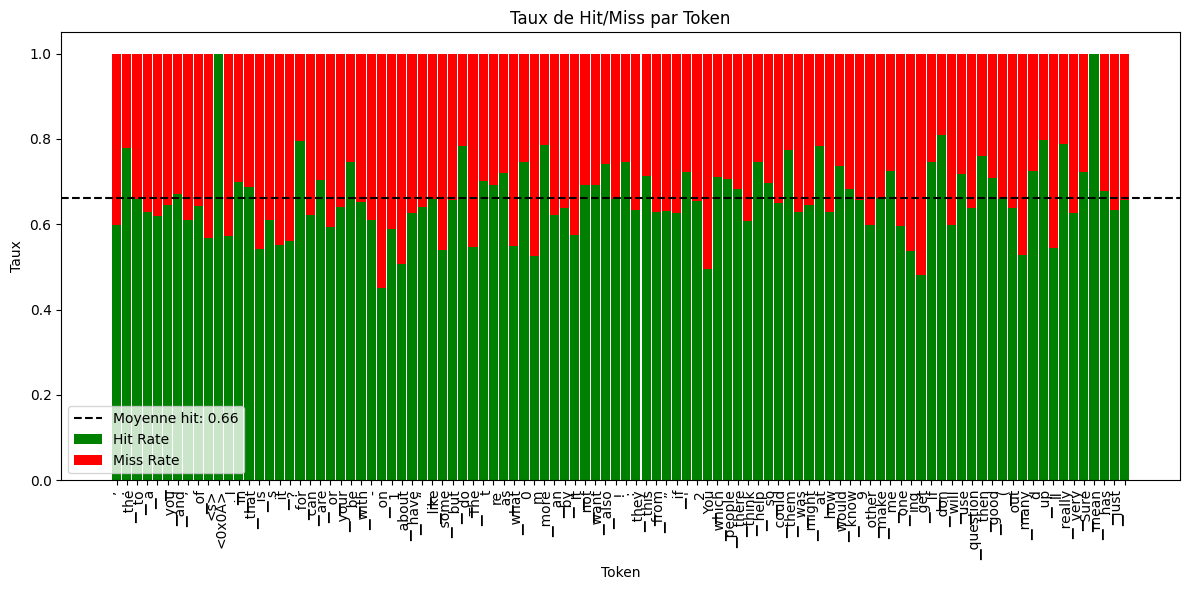

In [ ]:
vocab_id2tk = torch.load("id_to_token.pt")

def trace_preci_pred_tk(tokens, precision):
    """
    Trace le graphique des taux de hit et miss pour chaque token_id
    inputs :
    - tokens : liste de token_id
    - precision : liste de tuples (hit_rate, miss_rate) pour chaque token_id
    IMPORTANTE : les tokens et la précision doivent être dans le même ordre 
    (mais logique dans la construction de N_tokens_id et N_pred_1)
    """
    hit_rates = [hit for hit, _ in precision]
    miss_rates = [miss for _, miss in precision]
    avg_hit = np.mean(hit_rates)

    # Création du graphique
    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.9
    indices = np.arange(len(tokens))

    tokens_text = [vocab_id2tk[tk] for tk in tokens]

    # Barres vertes pour hits
    ax.bar(indices, hit_rates, bar_width, label='Hit Rate', color='green')

    # Barres rouges pour misses (empilées au-dessus)
    ax.bar(indices, miss_rates, bar_width, bottom=hit_rates, label='Miss Rate', color='red')

    # Ligne horizontale pour la moyenne
    ax.axhline(avg_hit, color='black', linestyle='--', linewidth=1.5, label=f'Moyenne hit: {avg_hit:.2f}')

    # Légendes et titres
    ax.set_xlabel('Token')
    ax.set_ylabel('Taux')
    ax.set_title('Taux de Hit/Miss par Token')
    ax.set_xticks(indices)
    ax.set_xticklabels(tokens_text, rotation=90, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.savefig("hit_miss_rates.png", dpi=300)
    plt.show()


trace_preci_pred_tk(N_tokens_id, precision_pred_deter_1)

100 tokens dans precisions_par_token


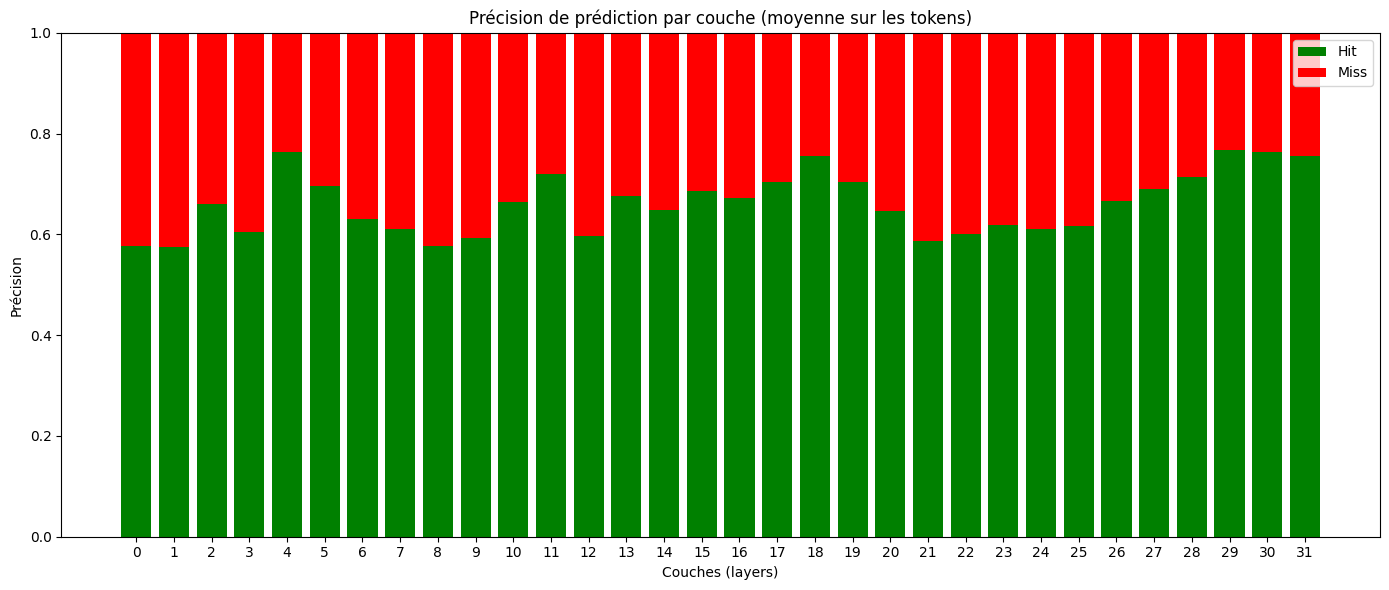

In [38]:
def trace_preci_pred_layer(tokens, precisions_par_token):
    """
    Trace un graphique en barres empilées montrant la précision (hit/miss) par couche.
    
    Inputs :
    - tokens : liste des token_id utilisés pour construire la précision (utile pour titre ou debug)
    - precisions_par_token : liste de tuples (hit_rate, miss_rate, hit_layer) pour chaque token
    """
    print(len(precisions_par_token), "tokens dans precisions_par_token")
    n_layers = 32
    n_tokens = len(precisions_par_token)

    # Moyenne du hit_layer par couche
    hit_layers_total = np.zeros(n_layers)

    for _, _, hit_layer in precisions_par_token:
        hit_layers_total += np.array(hit_layer)

    avg_hit_layer = hit_layers_total / n_tokens
    avg_miss_layer = 1 - avg_hit_layer

    # Tracé du graphe
    x = np.arange(n_layers)
    bar_width = 0.8

    fig, ax = plt.subplots(figsize=(14, 6))

    ax.bar(x, avg_hit_layer, bar_width, label='Hit', color='green')
    ax.bar(x, avg_miss_layer, bar_width, bottom=avg_hit_layer, label='Miss', color='red')

    ax.set_xlabel("Couches (layers)")
    ax.set_ylabel("Précision")
    ax.set_title("Précision de prédiction par couche (moyenne sur les tokens)")
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x])
    ax.set_ylim(0, 1)
    ax.legend()
    plt.tight_layout()
    plt.savefig("hit_miss_rates_layers.png", dpi=300)
    plt.show()


trace_preci_pred_layer(N_tokens_id, precision_pred_deter_1)

        
    